# Question 2

Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_validate, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, classification_report)
from sklearn.feature_selection import RFE
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Load the cleansed dataset and set LoanNr_ChkDgt as the index column
df = pd.read_csv("Final_SBA_Dataset_v3.csv", index_col = 0)


print(f"Dataset loaded: {df.shape[0]:,} rows × {df.shape[1]} columns\n")
display(df.head())

print("\nColumn Info:")
print(df.dtypes)

print("\nMissing values per column:")
print(df.isnull().sum())

Dataset loaded: 701,149 rows × 14 columns



,Term,NoEmp,GrAppv,Default,Is_New,Is_Franchise,Is_LowDoc,Is_RevLineCr,Is_Solo,CreatedJobs_Any,RetainedJobs_Any,SBA_Guarantee_Ratio,HighRisk_State,HighRisk_Industry
LoanNr_ChkDgt,,,,,,,,,,,,,,
1000014003,84,4,60000,0,1,0,1,0,0,0,0,0.80,0,1
1000024006,60,2,40000,0,1,0,1,0,0,0,0,0.80,0,1
1000034009,180,7,287000,0,0,0,0,0,0,0,0,0.75,0,0
1000044001,60,2,35000,0,0,0,1,0,0,0,0,0.80,0,0
1000084002,120,19,517000,0,0,0,0,0,0,0,0,0.75,0,0



Column Info:
Term                     int64
NoEmp                    int64
GrAppv                   int64
Default                  int64
Is_New                   int64
Is_Franchise             int64
Is_LowDoc                int64
Is_RevLineCr             int64
Is_Solo                  int64
CreatedJobs_Any          int64
RetainedJobs_Any         int64
SBA_Guarantee_Ratio    float64
HighRisk_State           int64
HighRisk_Industry        int64
dtype: object

Missing values per column:
Term                   0
NoEmp                  0
GrAppv                 0
Default                0
Is_New                 0
Is_Franchise           0
Is_LowDoc              0
Is_RevLineCr           0
Is_Solo                0
CreatedJobs_Any        0
RetainedJobs_Any       0
SBA_Guarantee_Ratio    0
HighRisk_State         0
HighRisk_Industry      0
dtype: int64


Inspect proportion of Defaults

In [3]:
print(df['Default'].value_counts(normalize=True))

Default
0    0.775769
1    0.224231
Name: proportion, dtype: float64


In [4]:
y = df.Default
x = df.drop(['Default'], axis =1)
y.value_counts()

Default
0    543930
1    157219
Name: count, dtype: int64

## (a) Logistic Regression on Full Dataset

Fit a logistic regression model on the dataset. Choose a probability threshold of 10%, 20%, 35% and 50%, to assign an observation to the Default = 1 class. Compute a confusion matrix for each of the probability thresholds. How do the True Positive and False Positive rates vary over these probability thresholds? Which probability threshold would you choose?

In [43]:
# Define X and y
X = df.drop(columns=["Default"])
y = df["Default"]

# Standardise the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Fit logistic regression on the full dataset (post EDA)
logreg = LogisticRegression(penalty="l2", solver="liblinear", max_iter=1000)
logreg.fit(X_scaled, y)

# Predict probabilities and compute AUC
y_probs = logreg.predict_proba(X_scaled)[:, 1]
auc_score = roc_auc_score(y, y_probs)

print(f"AUC (Full Dataset): {auc_score:.4f}")

AUC (Full Dataset): 0.7952


#### Threshold Evaluation (10%, 20%, 35% and 50%)

In [6]:
# Define threshold list
thresholds = [0.10, 0.20, 0.35, 0.50]

In [7]:
# Function to compute metrics
def compute_metrics_summary(y_true, y_probs, thresholds):
    results = []

    for thresh in thresholds:
        y_pred = (y_probs >= thresh).astype(int)
        TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()

        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0
        TNR = TN / (TN + FP) if (TN + FP) > 0 else 0
        FNR = FN / (FN + TP) if (FN + TP) > 0 else 0
        Accuracy = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
        Precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        F1 = 2 * (Precision * TPR) / (Precision + TPR) if (Precision + TPR) > 0 else 0
        ErrorRate = (FP + FN) / (TP + TN + FP + FN)
        GScore = np.sqrt(TPR * TNR) if TPR > 0 and TNR > 0 else 0

        results.append({
            "Threshold": thresh,
            "TPR (Recall)": round(TPR, 4),
            "FPR": round(FPR, 4),
            "FNR": round(FNR, 4),
            "TNR (Specificity)": round(TNR, 4),
            "Accuracy": round(Accuracy, 4),
            "Precision": round(Precision, 4),
            "F Score": round(F1, 4),
            "Error Rate": round(ErrorRate, 4),
            "G Score": round(GScore, 4)
        })

    return pd.DataFrame(results)

In [8]:
# Generate and display metrics table
metrics_table = compute_metrics_summary(y, y_probs, thresholds)
display(metrics_table)

,Threshold,TPR (Recall),FPR,FNR,TNR (Specificity),Accuracy,Precision,F Score,Error Rate,G Score
0,0.10,0.9145,0.6570,0.0855,0.3430,0.4711,0.2869,0.4368,0.5289,0.5601
1,0.20,0.8137,0.3528,0.1863,0.6472,0.6846,0.4000,0.5363,0.3154,0.7257
2,0.35,0.5547,0.1257,0.4453,0.8743,0.8026,0.5605,0.5576,0.1974,0.6964
3,0.50,0.2609,0.0369,0.7391,0.9631,0.8057,0.6716,0.3759,0.1943,0.5013


Display Confusion Matrices

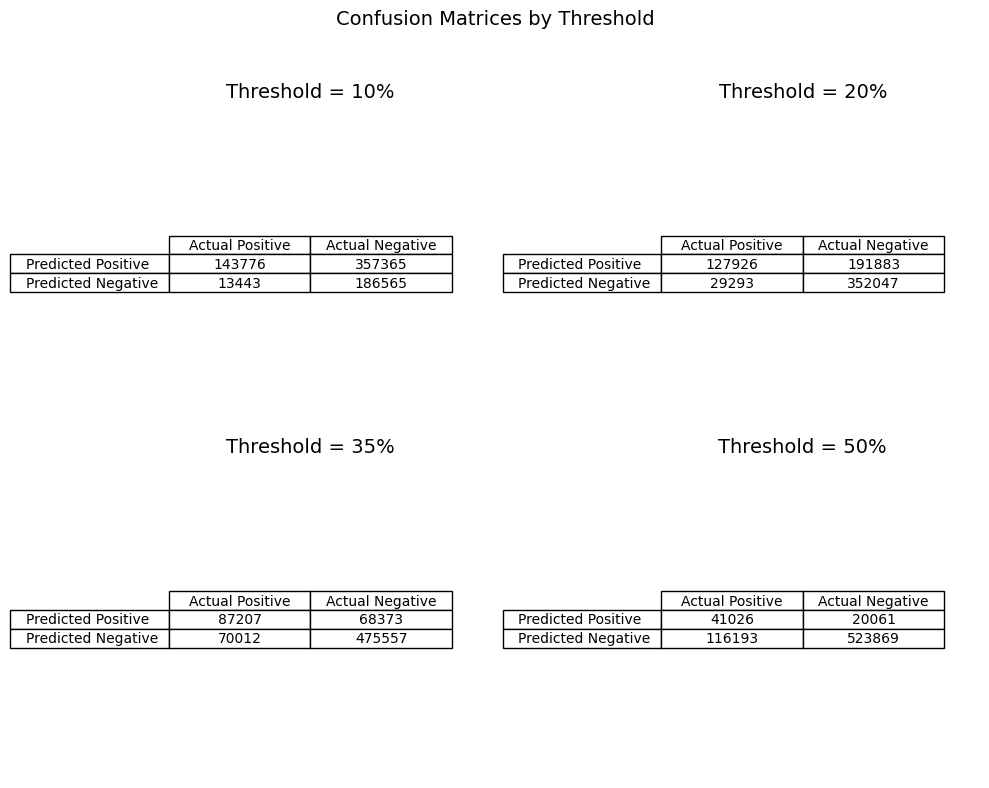

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for idx, t in enumerate(thresholds):
    y_pred = (y_probs >= t).astype(int)
    cm = confusion_matrix(y, y_pred)
    TN, FP, FN, TP = cm.ravel()
    
    count_matrix = np.array([[TP, FP], [FN, TN]])

    table_data = pd.DataFrame(
        count_matrix,
        index=["Predicted Positive", "Predicted Negative"],
        columns=["Actual Positive", "Actual Negative"]
    )

    axes[idx].axis("off")
    axes[idx].table(
        cellText=table_data.values,
        rowLabels=table_data.index,
        colLabels=table_data.columns,
        cellLoc="center",
        loc="center",
        colWidths=[0.4]*3
    )
    axes[idx].set_title(f"Threshold = {int(t*100)}%", fontsize=14)

plt.suptitle("Confusion Matrices by Threshold", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Plot showing evolution of metrics across the four thresholds

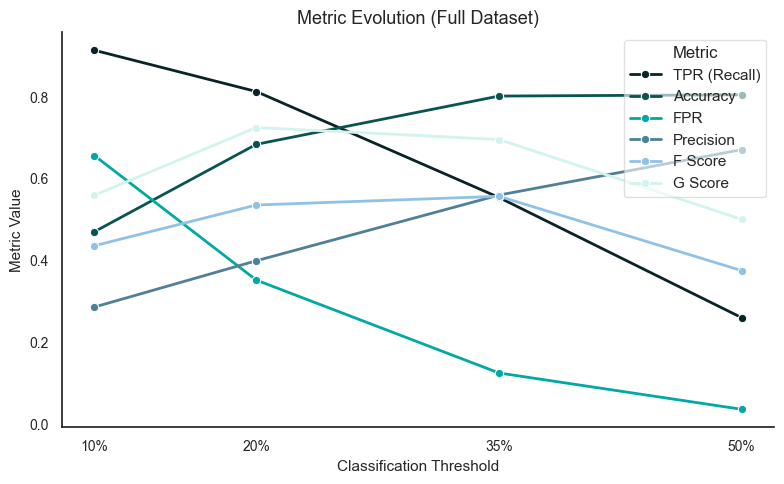

In [10]:
def plot_metric_evolution(metrics_df, title="Metric Evolution Across Thresholds (Test Set)", filename = "metric_evolution.png"):

    metrics_to_plot = ["TPR (Recall)", "Accuracy", "FPR", "Precision", "F Score", "G Score"]

    # Melt to long format for seaborn
    melted = metrics_df.melt(
        id_vars="Threshold",
        value_vars=metrics_to_plot,
        var_name="Metric",
        value_name="Value"
    )


    custom_palette = ["#092327", "#0B5351", "#00A9A5", "#4E8098", "#90C2E7", "#D3F3EE"]


    # Plot
    plt.figure(figsize=(8, 5))
    sns.set_style("white")
    sns.set_context("notebook")

    sns.lineplot(
        data=melted,
        x="Threshold",
        y="Value",
        hue="Metric",
        marker="o",
        palette=custom_palette,
        linewidth=2
    )

    plt.title(title, fontsize=13)
    plt.xlabel("Classification Threshold", fontsize=11)
    plt.ylabel("Metric Value", fontsize=11)
    plt.xticks([0.10, 0.20, 0.35, 0.50], labels=["10%", "20%", "35%", "50%"], fontsize=10)
    plt.yticks(fontsize=10)
    sns.despine()
    plt.grid(False)
    plt.legend(title="Metric", loc='upper right', frameon=True, fancybox = True, framealpha = 0.6)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

plot_metric_evolution(metrics_table, title="Metric Evolution (Full Dataset)", filename = "full_dataset_metric_evolution.png")

#### ROC Curve

In [11]:
def plot_roc_curve(y_true, y_probs, title="ROC Curve", filename="roc_curve.png"):

    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc_score = roc_auc_score(y_true, y_probs)

    plt.figure(figsize=(6, 5))
    sns.set_style("white")
    plt.plot(fpr, tpr, color= "#2f5166", linewidth=2, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="#bbc8d0", label="Random Classifier (AUC = 0.5)")

    plt.title(title, fontsize=12)
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (Recall / TPR)")
    plt.legend(frameon=False)
    plt.grid(False)
    sns.despine()
    plt.tight_layout()
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

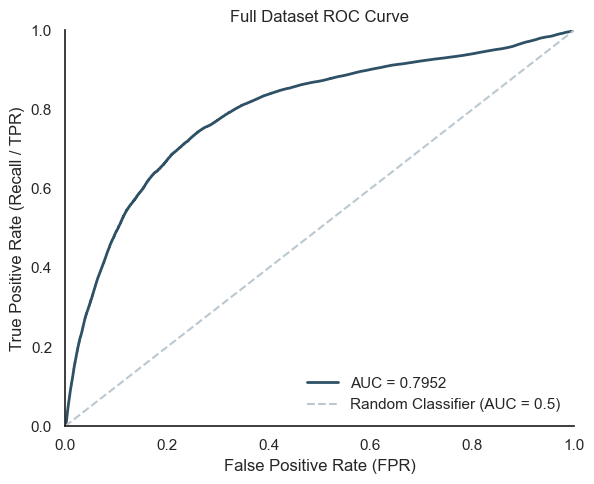

In [12]:
plot_roc_curve(y_true = y, y_probs = y_probs, title="Full Dataset ROC Curve", filename="full_dataset_roc_curve.png")

#### P-R Curve

In [13]:
def plot_pr_curve(y_true, y_probs, title="Precision-Recall Curve", filename="pr_curve.png"):

    precision, recall, _ = precision_recall_curve(y_true, y_probs)
    avg_precision = average_precision_score(y_true, y_probs)
    baseline = y_true.mean()

    plt.figure(figsize=(6, 5))
    sns.set_style("white")
    plt.plot(recall, precision, color= "#2f5166", linewidth=2, label=f"AP = {avg_precision:.4f}")
    plt.axhline(y=baseline, linestyle="--", color="#bbc8d0", label=f"Baseline = {baseline:.2f}")

    plt.title(title, fontsize=12)
    plt.xlabel("Recall (TPR)")
    plt.ylabel("Precision")
    plt.legend(frameon=False)
    plt.grid(False)
    sns.despine()
    plt.tight_layout()
    plt.xlim(0, 1)
    plt.ylim(0, 1)

    plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()

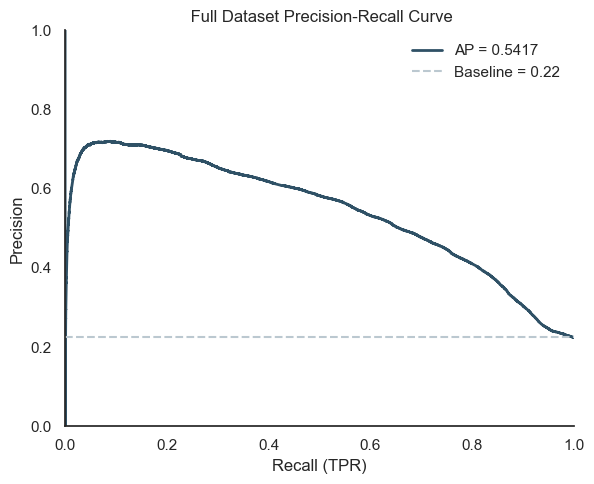

In [14]:
plot_pr_curve(y_true = y, y_probs = y_probs, title=" Full Dataset Precision-Recall Curve", filename="full_dataset_pr_curve.png")

## (b) Train/ Test Split (70/30)

 Divide the dataset into training (70%) and test (30%) sets and repeat the above question and
report the performance of these models, across probability thresholds, on the test set. In addition, describe and implement the cross-validation approach to estimate the test dataset model performance measurements.

In [15]:
# Split the dataset into 70% train / 30% test
X = df.drop(columns=["Default"])
y = df["Default"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Scale features independently for train and test
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit logistic regression on training set
logreg_test = LogisticRegression(penalty="l2", solver="liblinear", max_iter=1000)
logreg_test.fit(X_train_scaled, y_train)

# Predict probabilities on test set
y_test_probs = logreg_test.predict_proba(X_test_scaled)[:, 1]

# Evaluate AUC on test set
test_auc = roc_auc_score(y_test, y_test_probs)
print(f"AUC (Test Set): {test_auc:.4f}")

AUC (Test Set): 0.7951


#### Threshold Evaluation (10%, 20%, 35% and 50%)

,Threshold,TPR (Recall),FPR,FNR,TNR (Specificity),Accuracy,Precision,F Score,Error Rate,G Score
0,0.10,0.9147,0.6605,0.0853,0.3395,0.4685,0.2858,0.4356,0.5315,0.5572
1,0.20,0.8150,0.3541,0.1850,0.6459,0.6839,0.3995,0.5362,0.3161,0.7256
2,0.35,0.5529,0.1246,0.4471,0.8754,0.8031,0.5619,0.5574,0.1969,0.6957
3,0.50,0.2587,0.0364,0.7413,0.9636,0.8056,0.6727,0.3737,0.1944,0.4993


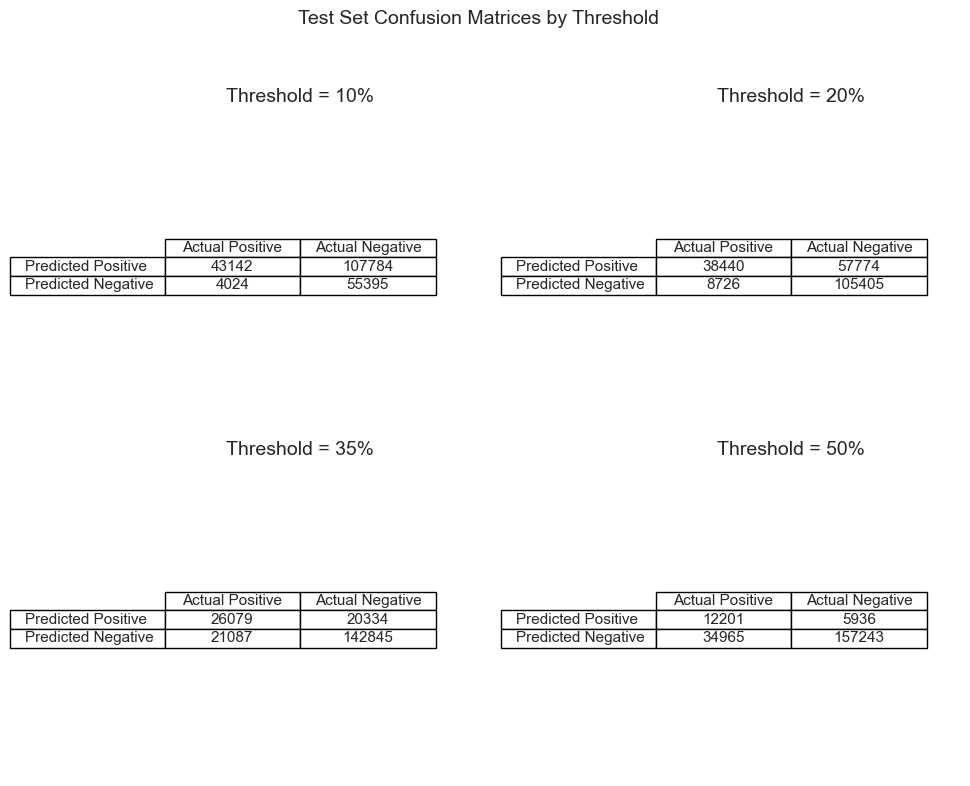

In [16]:
# Use the same threshold values
thresholds = [0.10, 0.20, 0.35, 0.50]

# Reuse compute_metrics_summary function on test set
metrics_table_test = compute_metrics_summary(y_test, y_test_probs, thresholds)
display(metrics_table_test)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.flatten()

for idx, t in enumerate(thresholds):
    y_pred = (y_test_probs >= t).astype(int)
    cm = confusion_matrix(y_test, y_pred)
    TN, FP, FN, TP = cm.ravel()
    
    count_matrix = np.array([[TP, FP], [FN, TN]])

    table_data = pd.DataFrame(
        count_matrix,
        index=["Predicted Positive", "Predicted Negative"],
        columns=["Actual Positive", "Actual Negative"]
    )


    axes[idx].axis("off")
    axes[idx].table(
        cellText=table_data.values,
        rowLabels=table_data.index,
        colLabels=table_data.columns,
        cellLoc="center",
        loc="center",
        colWidths=[0.4]*3
    )
    axes[idx].set_title(f"Threshold = {int(t*100)}%", fontsize=14)

plt.suptitle("Test Set Confusion Matrices by Threshold", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

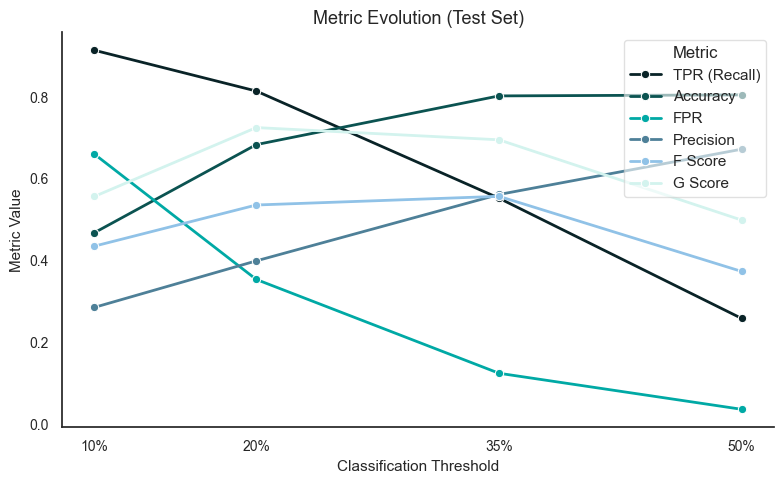

In [17]:
plot_metric_evolution(metrics_table_test, title = "Metric Evolution (Test Set)", filename = "test_set_metric_evolution.png")

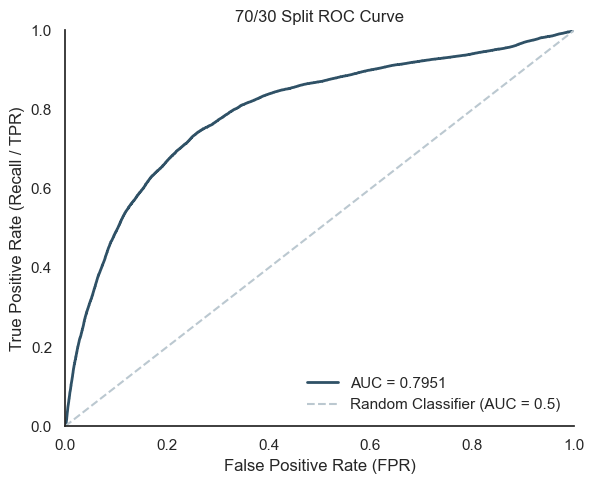

In [18]:
plot_roc_curve(y_true = y_test, y_probs = y_test_probs, title="70/30 Split ROC Curve", filename="70_30_roc_curve.png")

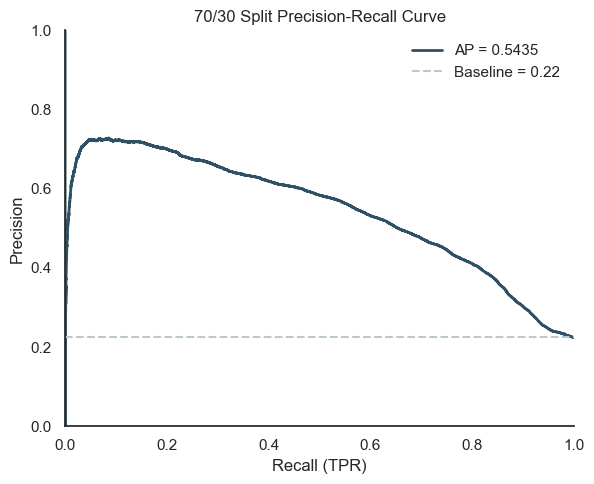

In [19]:
plot_pr_curve(y_true = y_test, y_probs = y_test_probs, title="70/30 Split Precision-Recall Curve", filename="70_30_pr_curve.png")

## K-Fold Cross-Validation

We have used Stratified K-Fold Cross Validation (to retain the underlying class distribution) using K = 5 and K = 10

In [44]:
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc',
    'neg_mse': 'neg_mean_squared_error'
}

# Define logistic regression model for CV
logreg_cv = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)

def run_cv_evaluation(X, y, n_splits):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    results = cross_validate(
        estimator=logreg_cv,
        X=X,
        y=y,
        scoring=scoring,
        cv=cv,
        return_train_score=False
    )

    summary = {}
    for metric in scoring:
        scores = results[f'test_{metric}']
        # Convert negative MSE back to positive
        if metric == 'neg_mse':
            scores = -scores
            name = 'mse'
        else:
            name = metric

        summary[name] = {
            f"{n_splits}-Fold Mean": scores.mean(),
            f"{n_splits}-Fold Std": scores.std()
        }

    return pd.DataFrame(summary).T

In [45]:
# Run 5-fold and 10-fold
cv_5 = run_cv_evaluation(X_train_scaled, y_train, n_splits=5)
cv_10 = run_cv_evaluation(X_train_scaled, y_train, n_splits=10)

# Combine into one table
cv_summary = pd.concat([cv_5, cv_10], axis=1)
display(cv_summary)

,5-Fold Mean,5-Fold Std,10-Fold Mean,10-Fold Std
accuracy,0.805507,0.000871,0.805476,0.001338
precision,0.672828,0.004263,0.672568,0.005192
recall,0.258131,0.003164,0.258133,0.004858
f1,0.373110,0.003808,0.373060,0.005630
roc_auc,0.794294,0.001561,0.794312,0.002336
mse,0.194493,0.000871,0.194524,0.001338


#### Perform at a specified probability threshold e.g. 20%

In [46]:
def run_pipeline_cv_threshold(X, y, threshold=0.20, n_splits=5):
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

    metrics = {
        'Accuracy': [], 'Precision': [], 'Recall': [], 'F1 Score': [], 'AUC': [], 'MSE': []
    }

    for train_idx, val_idx in cv.split(X, y):
        X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
        y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]

        pipeline = Pipeline([
            ("scaler", StandardScaler()),
            ("logreg", LogisticRegression(
                penalty='l2',
                solver='liblinear',
                max_iter=1000
            ))
        ])

        pipeline.fit(X_train_cv, y_train_cv)
        y_val_probs = pipeline.predict_proba(X_val_cv)[:, 1]
        y_val_pred = (y_val_probs >= threshold).astype(int)

        # Store metrics
        metrics['Accuracy'].append(accuracy_score(y_val_cv, y_val_pred))
        metrics['Precision'].append(precision_score(y_val_cv, y_val_pred, zero_division=0))
        metrics['Recall'].append(recall_score(y_val_cv, y_val_pred))
        metrics['F1 Score'].append(f1_score(y_val_cv, y_val_pred))
        metrics['AUC'].append(roc_auc_score(y_val_cv, y_val_probs))
        metrics['MSE'].append(mean_squared_error(y_val_cv, y_val_probs))  # based on probability

    return pd.DataFrame({
        "Mean": {k: np.mean(v) for k, v in metrics.items()},
        "Std": {k: np.std(v) for k, v in metrics.items()}
    })

In [47]:
cv_5 = run_pipeline_cv_threshold(X_train, y_train, threshold=0.20, n_splits=5)
cv_10 = run_pipeline_cv_threshold(X_train, y_train, threshold=0.20, n_splits=10)

pd.concat([cv_5, cv_10], axis=1, keys=["5-Fold", "10-Fold"])

5-Fold             10-Fold          
               Mean       Std      Mean       Std
Accuracy   0.682678  0.000676  0.682645  0.001165
Precision  0.398315  0.000350  0.398283  0.001589
Recall     0.813127  0.002534  0.813102  0.003020
F1 Score   0.534702  0.000719  0.534666  0.001672
AUC        0.794294  0.001561  0.794312  0.002336
MSE        0.137205  0.000464  0.137203  0.000862

#### Report full metrics across all four probability thresholds

In [24]:
for k in [5, 10]:
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fold_metrics = []

    for train_idx, val_idx in cv.split(X_train_scaled, y_train):
        X_fold_train, X_fold_val = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)
        model.fit(X_fold_train, y_fold_train)

        y_val_probs = model.predict_proba(X_fold_val)[:, 1]

        thresholds = [0.1, 0.20, 0.35, 0.50] 
        metrics_df = compute_metrics_summary(y_fold_val, y_val_probs, thresholds)
        fold_metrics.append(metrics_df)

    metrics_cv_summary = pd.concat(fold_metrics).groupby("Threshold").mean().round(4)
    print(f"\nCross-Validation Summary (K={k}):")
    display(metrics_cv_summary)


Cross-Validation Summary (K=5):


,TPR (Recall),FPR,FNR,TNR (Specificity),Accuracy,Precision,F Score,Error Rate,G Score
Threshold,,,,,,,,,
0.10,0.9143,0.6593,0.0857,0.3407,0.4693,0.2861,0.4358,0.5307,0.5581
0.20,0.8132,0.3548,0.1868,0.6452,0.6829,0.3985,0.5349,0.3171,0.7244
0.35,0.5535,0.1252,0.4465,0.8748,0.8027,0.5609,0.5571,0.1973,0.6958
0.50,0.2583,0.0363,0.7417,0.9637,0.8055,0.6726,0.3732,0.1945,0.4989



Cross-Validation Summary (K=10):


,TPR (Recall),FPR,FNR,TNR (Specificity),Accuracy,Precision,F Score,Error Rate,G Score
Threshold,,,,,,,,,
0.10,0.9145,0.6595,0.0855,0.3405,0.4692,0.2861,0.4359,0.5308,0.5581
0.20,0.8132,0.3548,0.1868,0.6452,0.6829,0.3985,0.5349,0.3171,0.7243
0.35,0.5534,0.1253,0.4466,0.8747,0.8026,0.5607,0.5570,0.1974,0.6958
0.50,0.2582,0.0363,0.7418,0.9637,0.8055,0.6727,0.3732,0.1945,0.4988


## Further Analysis

Excluded from the written report

### Undersampling the majority class

In [25]:
X_full = df.drop(columns="Default")
y_full = df["Default"]

X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.3, stratify=y_full, random_state=42
)

In [26]:
# Recombine temporarily
train_df = X_train.copy()
train_df['Default'] = y_train

# Undersample majority class in training set
df_majority = train_df[train_df['Default'] == 0]
df_minority = train_df[train_df['Default'] == 1]

df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=42)
df_balanced_train = pd.concat([df_majority_downsampled, df_minority]).sample(frac=1, random_state=42)

# Separate again
X_train_bal = df_balanced_train.drop(columns='Default')
y_train_bal = df_balanced_train['Default']

In [27]:
# Cross-validated performance on undersampled training set
cv_5_bal = run_pipeline_cv_threshold(X_train_bal, y_train_bal, threshold=0.20, n_splits=5)
cv_10_bal = run_pipeline_cv_threshold(X_train_bal, y_train_bal, threshold=0.20, n_splits=10)

# Compare performance across folds
pd.concat([cv_5_bal, cv_10_bal], axis=1, keys=["5-Fold", "10-Fold"])

5-Fold             10-Fold          
               Mean       Std      Mean       Std
Accuracy   0.572224  0.001319  0.572083  0.001673
Precision  0.541149  0.000824  0.541066  0.001074
Recall     0.949851  0.001075  0.949815  0.002095
F1 Score   0.689484  0.000650  0.689406  0.000764
AUC        0.788591  0.000650  0.788604  0.002099
MSE        0.191409  0.000242  0.191407  0.000841